In [1]:
from comet_ml import Experiment

import os, sys
sys.path.append('..')

CUDA_NUM = 1
os.environ["CUDA_VISIBLE_DEVICES"]=str(CUDA_NUM)


In [2]:
import torch
from torch import nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm as tqdm_notebook
from tqdm import tqdm as tqdm
import itertools

import seaborn as sns
from IPython.display import clear_output

from rich_utils import data_preprocessing, data_processing


In [3]:
PARTICLE_TYPE = 'kaon'
MODEL_NAME = "NF_{}_test".format(PARTICLE_TYPE)

BATCH_SIZE = int(1e3)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

NUM_LAYERS = 5

In [4]:
import logging

os.makedirs('log', exist_ok=True)
logging.basicConfig(filename=f'log/{MODEL_NAME}.log',
                    filemode='w',
                    format='%(asctime)s, %(funcName)s - %(levelname)s - %(message)s',
                    datefmt='%d-%b %H:%M:%S',
                    level=logging.DEBUG)
logger = logging.getLogger('main')
logging.info(f"Logging started. PARTICLE_TYPE:{PARTICLE_TYPE}, " +
             f"MODEL_NAME:{MODEL_NAME}, BATCH_SIZE:{BATCH_SIZE}, NUM_LAYERS:{NUM_LAYERS} " +
             f"device:{device}, CUDA_NUM:{CUDA_NUM}")


## Data

In [5]:
data_train, data_val, scaler = data_preprocessing.get_merged_typed_dataset(PARTICLE_TYPE, dtype=np.float32)


In [6]:
train_loader = data_processing.get_loader(data_train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = data_processing.get_loader(data_val, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [7]:
from torch import distributions
from torch.distributions import MultivariateNormal

from nflib.flows.spline import NSF_AR
from nflib.flows.glow import ActNorm
from nflib.flows.sequence import NormalizingFlowModel, InvertiblePermutation


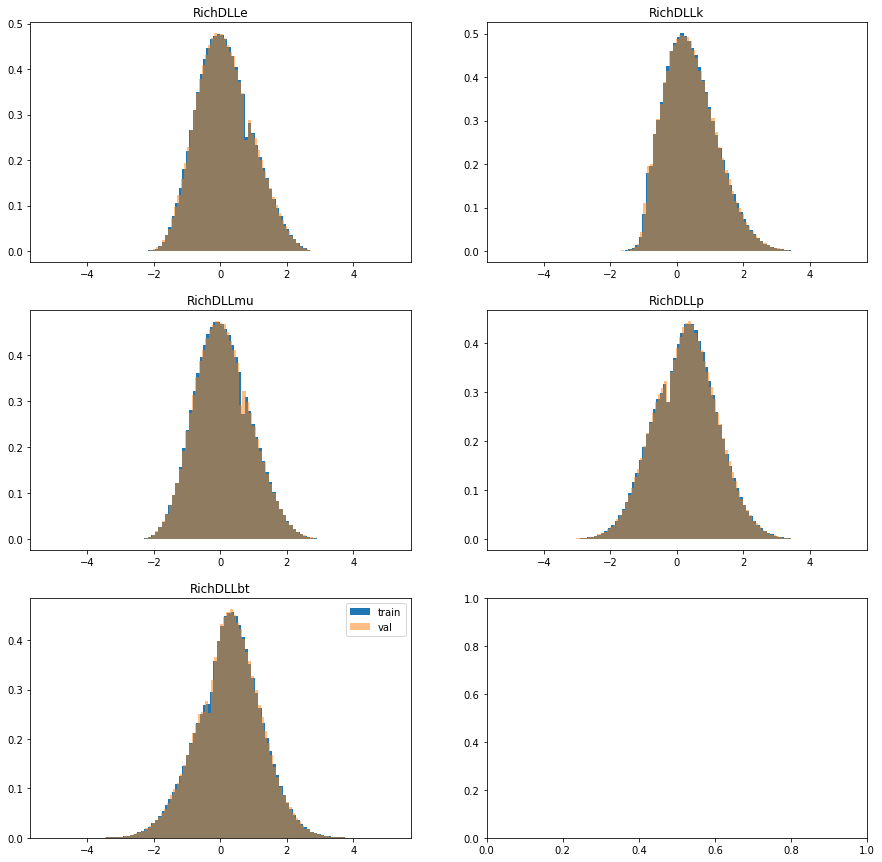

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
for INDEX, ax in zip((0, 1, 2, 3, 4), axes.flatten()):
    _, bins, _ = ax.hist(data_train[data_preprocessing.dll_columns].iloc[:, INDEX],
                         bins=100,
                         label="train",
                         density=True,
                         weights=data_train[data_preprocessing.weight_col].values.reshape(-1))
    ax.hist(data_val[data_preprocessing.dll_columns].iloc[:, INDEX],
                         bins=100,
                         label="val",
                         density=True,
                         alpha=0.5,
                         weights=data_val[data_preprocessing.weight_col].values.reshape(-1))
    ax.set_title(data_preprocessing.dll_columns[INDEX])

ax.legend()
plt.show()

## Model

In [9]:
dim = data_preprocessing.y_count
context=len(data_preprocessing.raw_feature_columns)

prior = MultivariateNormal(torch.zeros(dim).to(device), torch.eye(dim).to(device))

flows = []
for i in range(NUM_LAYERS):
    flows.append(NSF_AR(dim=dim, hidden_dim=32, context=context))
    flows.append(ActNorm(dim=dim))
    flows.append(InvertiblePermutation(dim=dim))

model = NormalizingFlowModel(prior, flows).to(device)
logger.info(f'Model assembled, {model}')

# optimizer
LR = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=LR) # todo tune WD
logger.info(f'LR-{LR}')
logger.info(f"number of params: {sum(p.numel() for p in model.parameters())}")


In [10]:
try:
    batch = next(iter(train_loader))
    x, weight, dll = [i.to(device) for i in batch]
    logging.debug(f"First forward batch passed, x.shape {x.shape}, weight.shape {weight.shape}, dll.shape {dll.shape}")
    zs, prior_logprob, log_det = model(dll, context=x)
except Exception as e:
    logging.error(f"Exception {e} occurred on first forward batch", exc_info=True)
else:
    logging.debug(f"First forward batch results, zs len {len(zs)}, zs[-1].shape {zs[-1].shape}, \
        prior_logprob.shape {prior_logprob.shape}, log_det.shape {log_det.shape}")


In [11]:
try:
    batch = next(iter(train_loader))
    x, weight, dll = [i.to(device) for i in batch]
    logging.debug(f"First sample batch passed, x.shape {x.shape}, weight.shape {weight.shape}, dll.shape {dll.shape}")
    sample = model.sample(BATCH_SIZE, context=x)
except Exception as e:
    logging.error(f"Exception {e} occurred on first sample batch", exc_info=True)
else:
    logging.debug(f"First samplebatch results, zs len {len(sample)}, zs[-1].shape {sample[-1].shape}")


## Train

In [12]:
MODEL_DIR = "./saved_models/"
os.makedirs('./' + MODEL_DIR, exist_ok=True)

TOTAL_ITERATIONS = int(1e5)
VALIDATION_INTERVAL = 5

In [13]:
experiment = Experiment(api_key="HIZapbzNjFips0c32Co7gXkQZ",
                        project_name="rich2019", workspace="maximartemev", disabled=False)
logger.info(f"Experiment is live on comet.ml, {experiment.focus_link + experiment.id}")

COMET INFO: old comet version (3.0.2) detected. current: 3.1.1 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET WARNING: Failing to collect the installed os packages
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/maximartemev/rich2019/705f4daa6ff0461da17eef8a8b0f51e7



In [14]:
def plot_compare(real, generated, weights, title):
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    for INDEX, ax in zip((0, 1, 2, 3, 4), axes.flatten()):
        _, bins, _ = ax.hist(real[:, INDEX],
                             bins=100,
                             label="data",
                             density=True,
                             weights=weights)
        ax.hist(generated[:, INDEX],
                bins=bins,
                label="generated",
                alpha=0.5,
                density=True,
                weights=weights)
        ax.legend()
        ax.set_title(data_preprocessing.dll_columns[INDEX])
    plt.title(title)


In [15]:
def log_batch(x, weight, dll, text=''):
    logger.debug(f"{text}" + \
        f"x stats: mean {x.mean()}, std {x.std()}, min {x.min()}, max {x.max()} \n" + \
        f"dll stats: mean {dll.mean()}, std {dll.std()}, min {dll.min()}, max {dll.max()} \n" + \
        f"weight stats: mean {weight.mean()}, std {weight.std()}, min {weight.min()}, max {weight.max()}")

def log_result(zs, prior_logprob, log_det, text=''):
    zs_ = zs[-1]
    logger.debug(f"{text}" + \
                    f"zs stats: len {len(zs)}, zs[-1].mean {zs_.mean()}, zs[-1].std {zs_.std()}, zs[-1].min {zs_.min()}, zs[-1].max {zs_.max()} \n" + \
                    f"prior_logprob stats: mean {prior_logprob.mean()}, std {prior_logprob.std()}, min {prior_logprob.min()}, max {prior_logprob.max()} \n" + \
                    f"log_det stats: mean {log_det.mean()}, std {log_det.std()}, min {log_det.min()}, max {log_det.max()}"
                            )
    

In [16]:
model.train()
for epoch in tqdm(range(TOTAL_ITERATIONS), position=0, leave=True):
    logger.info(f"Epoch {epoch}/{TOTAL_ITERATIONS}, start")
    for batch_ind, batch in tqdm_notebook(enumerate(train_loader), total=len(train_loader), leave=False):
        step = epoch * len(train_loader) + batch_ind
        log_text = f"Epoch {epoch}/{TOTAL_ITERATIONS}, batch {batch_ind}/{len(train_loader)} \n"
        x, weight, dll = [i.to(device) for i in batch]
        zs, prior_logprob, log_det = model(dll, context=x)

        if batch_ind % 100 == 0:
            log_batch(x, weight, dll, log_text)
            zs_ = zs[-1]
            log_result(zs, prior_logprob, log_det, log_text)
        
        logprob = prior_logprob + log_det
        loss = -torch.sum(logprob) # NLL
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        experiment.log_metric('loss', loss.item(), step=step)
        
    if epoch % VALIDATION_INTERVAL == 0:
        model.eval()
        clear_output(False)
        x = data_val[data_preprocessing.raw_feature_columns].values
        dll = data_val[data_preprocessing.dll_columns].values
        weights = data_val[data_preprocessing.weight_col].values.reshape(-1)
        log_text = f"Epoch {epoch}/{TOTAL_ITERATIONS}, Eval mode \n"
        log_batch(x, weight, dll, log_text)
        generated = torch.cat([model.sample(BATCH_SIZE, context=x_batch.to(device))[-1].cpu().detach()
                               for x_batch, _, _ in tqdm_notebook(val_loader, desc='val loop')], dim=0)
        logger.debug(f"{log_text} " + 
                     f"generated stats: mean {generated.mean()}, std {generated.std()}, min {generated.min()}, max {generated.max()}")

        plot_compare(dll, generated, weights, title='transformed')
        experiment.log_figure('transformed', step=epoch)
        plt.show()

        inversed_real = scaler.inverse_transform(np.column_stack([dll, x]))[:, :dll.shape[1]]
        inversed_generated = scaler.inverse_transform(np.column_stack([generated, x]))[:, :generated.shape[1]]

        plot_compare(inversed_real, inversed_generated, weights, title='inverse transformed')
        experiment.log_figure('inverse transformed', step=epoch)
        plt.show()

experiment.end()

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 42/100000 [11:02:57<26165:16:20, 942.35s/it]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 43/100000 [11:17:49<25746:51:45, 927.29s/it]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 45/100000 [11:47:32<25237:14:44, 908.95s/it]

KeyboardInterrupt: 

In [ ]:
1

In [ ]:
logger.info(f"Saving to {os.path.join(MODEL_DIR, MODEL_NAME + '.state_dict')}")
torch.save(model.state_dict(), os.path.join(MODEL_DIR, MODEL_NAME + '.state_dict'))

from sklearn.externals import joblib
os.makedirs('./preprocessors', exist_ok=True)
logger.info(f"Saving to {'preprocessors/' + MODEL_NAME + '.state_dict'}")
joblib.dump(scaler, os.path.join('preprocessors', MODEL_NAME) + "_preprocessor.pkl")


### Evaluate with classifier

In [ ]:
pred_dlls_ = []
for batch in tqdm(val_loader, position=0, leave=True):
    x, weight, dlls = [i.to(device) for i in batch]
    pred_dlls_.append(model.sample(BATCH_SIZE)[-1].cpu().detach().numpy())

In [ ]:
pred_dlls = np.concatenate(pred_dlls_, axis=0)
pred_data = np.concatenate([pred_dlls, data_val.values[:, data_preprocessing.y_count:-1]], axis=1)

pred_data_inversed = scaler.inverse_transform(pred_data)
val_data_inversed = scaler.inverse_transform(data_val.iloc[:, :-1])


In [ ]:
val_data_inversed_ = pd.DataFrame(val_data_inversed,
                                  columns=data_val.columns[:-1])
for ind, col in enumerate(data_preprocessing.dll_columns):
    val_data_inversed_["predicted_"+col] = pred_data_inversed[:, ind]
val_data_inversed_['probe_sWeight'] = data_val['probe_sWeight']

In [ ]:
class Wrapper:
    def __init__(self, data):
        self.test = data

wrap = lambda x, particle: {particle: Wrapper(x)}

In [ ]:
from rich_utils.model_testing import eval_model

scores, bins = eval_model(PARTICLE_TYPE, wrap(val_data_inversed_, PARTICLE_TYPE))

In [ ]:
print("Particle: {}, global test score: {} +- {}".format(PARTICLE_TYPE,
                                                         scores.mean(axis=0)[0][1],
                                                         scores.std(axis=0)[0][1]))

logger.info("Particle: {}, global test score: {} +- {}".format(PARTICLE_TYPE,
                                                         scores.mean(axis=0)[0][1],
                                                         scores.std(axis=0)[0][1]))
